In [69]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm

from KalmanFilter import KalmanFilter


We'll first estimate the local level model giving us the chance of writing the Kalman filter algorithm which, if there's time, can be re-used for the DSGE model.

# The Model

as described in the chapter 4 in Koopman et al. The local level model with a seasonal component consists of the following equations:

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


We added a $\theta$ coefficient in order to use maximum likelihood estimation

## State Space Form

General Form:

$$ y_t = Z x_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$
$$ x_{t+1} = T x_t + R_t \eta_T, \qquad \eta_t \sim NID(0,Qt) $$

In terms of the model:
$$ 
x_t = 
\begin{pmatrix}\mu_t \\ \gamma_t  \\  \gamma_{t-1}   \\ \gamma_{t-2}  \end{pmatrix}
$$

$$
\eta_t = 
\begin{pmatrix}\xi_t \\ \omega_t \end{pmatrix}
$$

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$


$$
Z^T_t = 
\begin{pmatrix}1 \\ 1  \\  0   \\ 0  \end{pmatrix}
$$

$$
Q_t = 
\begin{bmatrix} 
\sigma^2_\xi & 0 \\
0 & \omega^2_\zeta \\
\end{bmatrix}
$$

$$
R_t = 
\begin{bmatrix} 
1 & 0  \\
0 & 1  \\
0 & 0  \\
0 & 0  \\
\end{bmatrix}
$$

# Generating the data for $\theta_1=1$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 2$$
$$\omega^2_\zeta = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [2]:
n = 1000
theta1 = 1
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

In [3]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

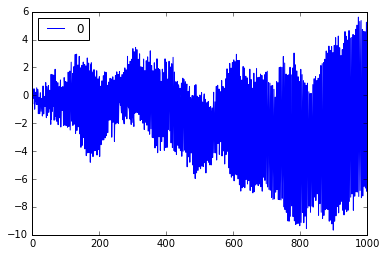

In [4]:
y.plot()

## Filtering States

In [5]:
T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-1],
        [0,1,0,0],
        [0,0,1,0],
    ])
T

,0,1,2,3
0,1,0,0,0
1,0,-1,-1,-1
2,0,1,0,0
3,0,0,1,0


In [6]:
Z = pd.DataFrame([
        [1,1,0,0],
    ])
Z

,0,1,2,3
0,1,1,0,0


In [7]:
R = pd.DataFrame([
        [1,0],
        [0,1],
        [0,0],
        [0,0],
    ])
R

,0,1
0,1,0
1,0,1
2,0,0
3,0,0


In [8]:
H = pd.DataFrame([0.3])
H

,0
0,0.3


In [9]:

Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])
Q

,0,1
0,0.1,0.0
1,0.0,0.2


In [10]:
a1 = pd.DataFrame([0,0,0,0])
a1

,0
0,0
1,0
2,0
3,0


In [11]:
P1 = pd.DataFrame(np.diag([1,1,1,1]))
P1

,0,1,2,3
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


In [12]:
kf = KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4)
kf.runFilter()

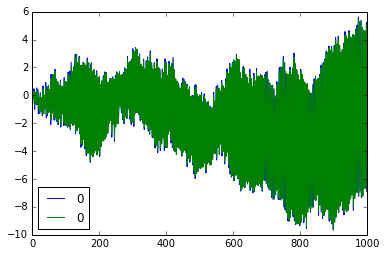

In [13]:
pd.concat([kf.y , kf.yhat],axis=1).plot()

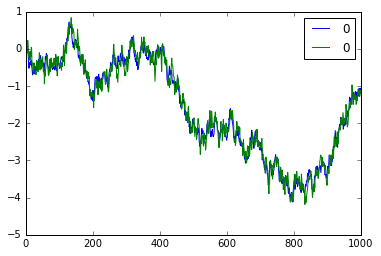

In [14]:
pd.concat([mi , kf.a[0]],axis=1).plot()

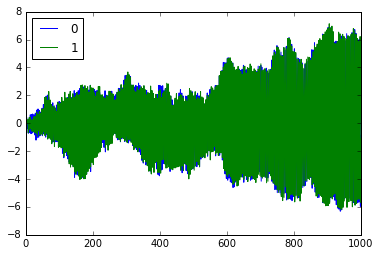

In [15]:
pd.concat([gamma , kf.a[1]],axis=1).plot()

# Maximum likelihood estimates

## Generating the data for $\theta_1=0.3$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 2$$
$$\omega^2_\zeta = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [22]:
n = 150
theta1 = 0.2
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

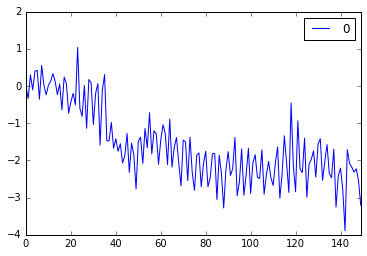

In [23]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

y.plot()

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$



In [46]:
def wrapper(theta):
    
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])
    
    H = pd.DataFrame([theta[1]])
    
    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])
    
    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4)    
    
    return kf.likelihood()

In [25]:
KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4).likelihood()

188.6978415364226

In [48]:
# minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), options={'disp':True, 'maxiter':100}, method='BFGS')

minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
         options={'disp':True, 'maxiter':200}, 
         bounds = ((-5,5),(0,5),(0,5),(0,5),), 
         )

# minimize(wrapper,np.array([0.0,1.0,1.0]), 
#          options={'disp':True, 'maxiter':1000}, 
#          bounds = ((0,2),(0,2),(0,2),),
#          method='SLSQP')

      fun: nan
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-29.16168   ,  18.87785288,  24.44973575,  27.2725913 ])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 105
      nit: 0
   status: 2
  success: False
        x: array([ 0.,  1.,  1.,  1.])

# Bayesian Estimates

## Metropolis Hastings

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i)}$
Draw $\theta'\sim q(\theta'|\theta)$
2. Compute $r=\min(1,\alpha)$ where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

---

In [89]:
def posterior(theta,priorMeans, priorVariances):
    
    temp = 1
    for i in range(0,priorMeans.shape[0]):
        temp *= norm.pdf(theta[i],priorMeans[i],priorVariances[i])
    
    return wrapper(theta) * temp

In [124]:
# %%timeit -n 3

sample = 10000

thetaMH = []
accept = np.zeros([sample])

thetaMH.append(np.array([0.5,0.1,0.1,0.1]))

sigmas = np.array([1,1,1,1])


priorMeans = np.array([0,0,0])

priorVariances = np.array([10,10,10])

for i in range(1,sample):
    disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),sigmas)
#     print(disturbance)
    thetaTemp = (thetaMH[i-1] + disturbance)
    lalpha = np.log(posterior(thetaTemp,priorMeans, priorVariances)) - np.log(posterior(thetaMH[i-1],priorMeans, priorVariances))
    r = np.min([1, np.exp(lalpha)])
    
    u = np.random.uniform()
    
    if u < r:
        accept[i] = 1
        thetaMH.append(thetaTemp)
    else:
        thetaMH.append(thetaMH[i-1])
    
    

KeyboardInterrupt: 

In [ ]:
post = pd.DataFrame(thetaMH)

In [ ]:
accept.sum() / accept.shape[0]

In [ ]:
parameter = 0

In [ ]:
post[parameter].iloc[500:].median()

In [ ]:
post[parameter].iloc[500:].mean()

In [ ]:
post[parameter].iloc[500:].hist()